# DTSA 5509: Supervised Learning Final Project

## Project Overview  
### Explanation  
This project will look at data from the UCI Machine Learning Repository focused on survivability of patients after a heart attack. We will be employing various types of decision tree classifiers in an attempt to find a model which can reliabily predict whether a patient will survive for a year after the event.
### Goal
For this project, we are going to look at data related to the survivability after a patient has suffered a heart attack. This information along with a well trained model could help doctors understand what factors to look for when examining patients. Similarly, this will help patients get better insight into their risk profile which hopefully encourages them to make lifestyle changes.

In [44]:
# Setup steps
# - Import libraries needed for project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Data  
### Source  
The data for this project was sourced from the UCI Machine Learning Repository. The data was taken from patients who had suffered a heart attack in the past. Its target was to determine whether the patient would survive for a year after the heart attack. 132 samples exist in the set, each with 13 attributes about the patient are included. A full list taken from the UCI ML Repository are included below.  
1. survival -- the number of months patient survived (has survived, if patient is still alive). Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive. Check the second variable to confirm this. Such patients cannot be used for the prediction task mentioned above.
2. still-alive -- a binary variable. 0=dead at end of survival period, 1 means still alive
3. age-at-heart-attack -- age in years when heart attack occurred
4. pericardial-effusion -- binary. Pericardial effusion is fluid around the heart. 0=no fluid, 1=fluid
5. fractional-shortening -- a measure of contracility around the heart lower numbers are increasingly abnormal
6. epss -- E-point septal separation, another measure of contractility. Larger numbers are increasingly abnormal.
7. lvdd -- left ventricular end-diastolic dimension. This is a measure of the size of the heart at end-diastole. Large hearts tend to be sick hearts.
8. wall-motion-score -- a measure of how the segments of the left ventricle are moving
9. wall-motion-index -- equals wall-motion-score divided by number of segments seen. Usually 12-13 segments are seen in an echocardiogram. Use this variable INSTEAD of the wall motion score.
10. mult -- a derivate var which can be ignored
11. name -- the name of the patient (I have replaced them with "name")
12. group -- meaningless, ignore it
13. alive-at-1 -- Boolean-valued. Derived from the first two attributes. 0 means patient was either dead after 1 year or had been followed for less than 1 year. 1 means patient was alive at 1 year.  

**Citation:** Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.  
**Direct Link:** https://archive.ics.uci.edu/ml/datasets/Echocardiogram

In [2]:
# Initial data import and investigation
# - Import data
# - Get data size
# - Print first 5 rows to validate import

col_names = ['SurvivalMonths', 'StillAlive', 'AgeAtHeartAttack', 'PericardialEffusion',
             'FractionalShortening', 'EPSS', 'LVDD', 'WallMotionScore', 'WallMotionIndex',
             'MULT', 'Name', 'Group', 'AliveAt1']
ecg_data = pd.read_csv('echocardiogram.data', header=None, names=col_names)

shape = ecg_data.shape
print(f'Data size includes: {shape[0]} samples, {shape[1]} attributes')
ecg_data.head()

Data size includes: 132 samples, 13 attributes


,SurvivalMonths,StillAlive,AgeAtHeartAttack,PericardialEffusion,FractionalShortening,EPSS,LVDD,WallMotionScore,WallMotionIndex,MULT,Name,Group,AliveAt1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


### Cleaning  
#### Drop unnecessary columns
From the description of the attributes, we can tell that there are several that are not actually useful and can be dropped immediately. This include names (which have been sanitized in the original dataset), mult, and group.

In [3]:
# Drop Name, MULT, and Group columns
ecg_data = ecg_data.drop(['Name', 'MULT', 'Group'], axis=1)
ecg_data.head()

,SurvivalMonths,StillAlive,AgeAtHeartAttack,PericardialEffusion,FractionalShortening,EPSS,LVDD,WallMotionScore,WallMotionIndex,AliveAt1
0,11,0,71,0,0.260,9,4.600,14,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0
2,16,0,55,0,0.260,4,3.420,14,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0


#### Reviewing data and cleaning up some missing values
Next we are going to take some precursory looks at our data. First comes unique values out of which we discover that this data set uses '?' to represent incomplete responses. We will swap that out to numpy's NaN value.

In [4]:
# Unique values for each column
for col in ecg_data.columns:
    print(f"Column Name: {col}, {ecg_data[col].unique()}")

Column Name: SurvivalMonths, ['11' '19' '16' '57' '26' '13' '50' '25' '10' '52' '44' '0.5' '24' '22'
 '1' '0.75' '5' '48' '29' '0.25' '36' '03' '27' '35' '31' '32' '40' '46'
 '2' '37' '19.5' '20' '?' '7' '12' '45' '53' '38' '9' '49' '47' '41' '.25'
 '33' '15' '.03' '23' '34' '21' '55' '4' '1.25' '.75' '3' '28' '17' '7.5']
Column Name: StillAlive, ['0' '1' '?']
Column Name: AgeAtHeartAttack, ['71' '72' '55' '60' '57' '68' '62' '46' '54' '77' '73' '69' '62.529' '66'
 '85' '64' '35' '75' '65' '52' '?' '47' '63' '61' '80' '70' '79' '56' '67'
 '81' '59' '58' '51' '50' '78' '86' '74' '53' '48']
Column Name: PericardialEffusion, ['0' '1' '?']
Column Name: FractionalShortening, ['0.260' '0.380' '0.253' '0.160' '0.230' '0.330' '0.340' '0.140' '0.130'
 '0.450' '0.150' '0.120' '0.250' '0.070' '0.090' '0.220' '0.180' '0.170'
 '0.190' '0.300' '?' '0.210' '0.400' '0.610' '0.060' '0.510' '0.410'
 '0.350' '0.270' '0.440' '0.030' '0.040' '0.240' '0.010' '0.290' '0.15'
 '0.13' '0.10' '0.29' '0.17' '0.12

In [5]:
# Replace all '?' with NA values to make the data easier to work with
ecg_data = ecg_data.replace('?', np.NaN)

#### How many values are missing and what rows are they from
For each column we will determine how many are missing values and determine if there are any overlap.

In [6]:
# Check how many values are missing for each column
rows_with_missing_values = set()

for col in ecg_data.columns:
    print(f"{col}, Missing: {ecg_data[col].isna().sum()}")
    
    if col != 'AliveAt1':
        rows_with_missing_values.update(ecg_data.index[ecg_data[col].isna()].tolist())
        
print(f"There are {len(rows_with_missing_values)} rows with missing values.")
print(rows_with_missing_values)

SurvivalMonths, Missing: 2
StillAlive, Missing: 1
AgeAtHeartAttack, Missing: 5
PericardialEffusion, Missing: 1
FractionalShortening, Missing: 8
EPSS, Missing: 15
LVDD, Missing: 11
WallMotionScore, Missing: 4
WallMotionIndex, Missing: 1
AliveAt1, Missing: 58
There are 26 rows with missing values.
{27, 28, 30, 32, 34, 36, 37, 38, 39, 43, 45, 46, 48, 49, 50, 51, 59, 61, 77, 84, 94, 100, 101, 116, 119, 125}


#### Dropping rows with missing values
As noted previously, there are 26 rows with missing values (not counting our target column AliveAt1). This is a not insignificant number of our sample. For the sake of this project we are going to drop these rows, however in practice we would likely want to address why these values are not available in the experiment.

In [7]:
# Drop rows with missing values
ecg_data = ecg_data.drop(rows_with_missing_values, axis=0)

In [8]:
for col in ecg_data.columns:
    print(f"{col}, Missing: {ecg_data[col].isna().sum()}")

SurvivalMonths, Missing: 0
StillAlive, Missing: 0
AgeAtHeartAttack, Missing: 0
PericardialEffusion, Missing: 0
FractionalShortening, Missing: 0
EPSS, Missing: 0
LVDD, Missing: 0
WallMotionScore, Missing: 0
WallMotionIndex, Missing: 0
AliveAt1, Missing: 45


#### Convert columns to correct types  
Looking at the types of columns (below), we can see that many are not in the correct format. We will convert them to the correct types.

In [9]:
# Print column types
ecg_data.dtypes

SurvivalMonths          object
StillAlive              object
AgeAtHeartAttack        object
PericardialEffusion     object
FractionalShortening    object
EPSS                    object
LVDD                    object
WallMotionScore         object
WallMotionIndex         object
AliveAt1                object
dtype: object

In [10]:
# Convert columns to proper data types
data_types = {'SurvivalMonths': 'float', 
              'StillAlive': 'int', 
              'AgeAtHeartAttack': 'float', 
              'PericardialEffusion': 'int',
              'FractionalShortening': 'float', 
              'EPSS': 'float', 
              'LVDD': 'float', 
              'WallMotionScore': 'float', 
              'WallMotionIndex': 'float',
              'AliveAt1': 'float'}
ecg_data = ecg_data.astype(data_types)

In [11]:
# Print column types
ecg_data.dtypes

SurvivalMonths          float64
StillAlive                int64
AgeAtHeartAttack        float64
PericardialEffusion       int64
FractionalShortening    float64
EPSS                    float64
LVDD                    float64
WallMotionScore         float64
WallMotionIndex         float64
AliveAt1                float64
dtype: object

#### Fill in missing values of AliveAt1 Column  
We will note that there are still missing values in our AliveAt1 target column. This can be calculated from the SurvivalMonths column by checking to see if that value is great than 12.

In [12]:
# Calculate values for AliveAt1 column
ecg_data['AliveAt1'] = ecg_data['SurvivalMonths'] >= 12

In [13]:
for col in ecg_data.columns:
    print(f"{col}, Missing: {ecg_data[col].isna().sum()}")

SurvivalMonths, Missing: 0
StillAlive, Missing: 0
AgeAtHeartAttack, Missing: 0
PericardialEffusion, Missing: 0
FractionalShortening, Missing: 0
EPSS, Missing: 0
LVDD, Missing: 0
WallMotionScore, Missing: 0
WallMotionIndex, Missing: 0
AliveAt1, Missing: 0


### Exploratory Data Analysis
For an initial exploration of our data, we will look at a histogram representing the number of months survived. We can see from this that approximately three out of every four of our heart attack patients did survive to the one year mark.

array([[<AxesSubplot:title={'center':'SurvivalMonths'}>]], dtype=object)

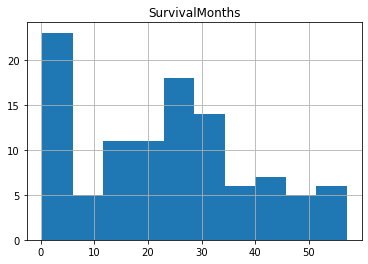

In [14]:
# Histogram binning number of months survived
ecg_data.hist(column='SurvivalMonths')

#### Attribute exploration
Next we will look at a correlation matrix. From the chart below, we can see that the attributes SurvivalMonths, StillAlive, and AliveAt1 are all highly correlated.  

This makes sense as they are all essentially measuring the same thing, survivability. As such, we should be sure not to include two of these when making models. Since we are looking at predicting whether a patient will make it to 1 year, that is the attribute we will keep.

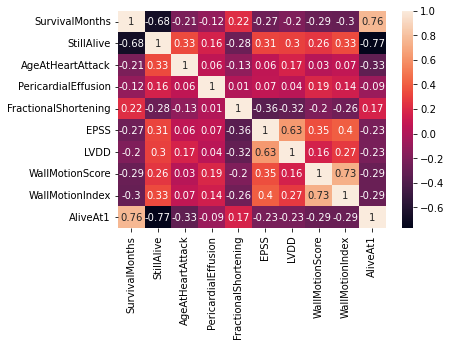

In [15]:
# Correlation matrix
corr_matrix = ecg_data.corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.show()

## Models  
For this project, we are going to rely on decision trees to create a model which can predict whether a patient will live for a year. First we will start with a simple decision tree and then we will move on to ensemble methods to create a more accurate model.

#### Split data into training and test sets

In [16]:
# Split data
ecg_X_train, ecg_X_test, ecg_Y_train, ecg_Y_test = train_test_split(
    ecg_data.drop(['AliveAt1', 'SurvivalMonths', 'StillAlive'] ,axis=1), 
    ecg_data['AliveAt1'],
    test_size=.20,
    random_state=13)

#ecg_Y_train = ecg_Y_train.astype('int')
#ecg_Y_test = ecg_Y_test.astype('int')

#### Simple Decision Tree

In [17]:
# Create basic decision tree model
ecg_dtc = DecisionTreeClassifier().fit(ecg_X_train, ecg_Y_train)

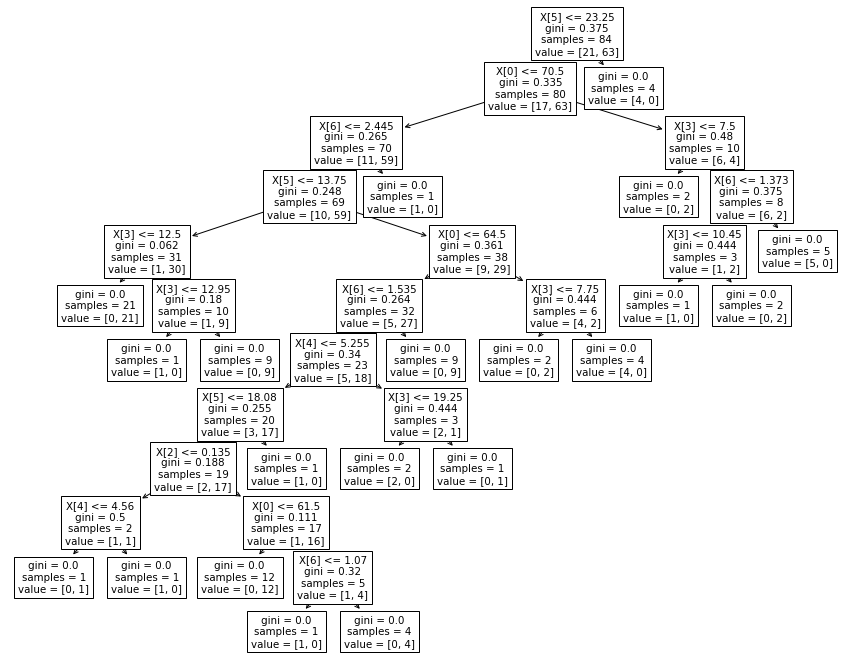

In [18]:
plt.figure(figsize=(15,12))
tree.plot_tree(ecg_dtc)
plt.show()

#### Accuracy of our model
Next we will look at several components to determine how accurate our model is.

In [20]:
# Generate predictions for both training and test data sets
ecg_predict_train = ecg_dtc.predict(ecg_X_train)
ecg_predict_test = ecg_dtc.predict(ecg_X_test)

In [23]:
# Determine accuracy for test and training predictions
acc_train = metrics.accuracy_score(ecg_Y_train, ecg_predict_train, normalize=True)
acc_test = metrics.accuracy_score(ecg_Y_test, ecg_predict_test, normalize=True)
print(f"Accuracy of predictions for training set: {acc_train}")
print(f"Accuracy of predictions for test set: {acc_test}")

Accuracy of predictions for training set: 1.0
Accuracy of predictions for test set: 0.7272727272727273


#### Interpretting Accuracy and Hyperparameter Tuning
We can see from our accuracy scores that we obtained an accuracy of 1 on our training set. This likely indicates that we are overfitting the data a bit. One method we can use to avoid this is to attempt to tune the maximum depth allowed in our tree.  

Currently our tree is allowed to expand indefinitely. We will create tree ranging from 1 to 10 and determine the accuracy scores associated with them.

In [42]:
# Repeat tree fitting with values from 1 to 10
N = np.arange(1,11)
accuracy_test = []
accuracy_train = []

for n in N:
    ecg_dtc_max_depth = DecisionTreeClassifier(max_depth=n).fit(ecg_X_train, ecg_Y_train)
    
    ecg_predict_train_md = ecg_dtc_max_depth.predict(ecg_X_train)
    ecg_predict_test_md = ecg_dtc_max_depth.predict(ecg_X_test)
    
    accuracy_test.append(metrics.accuracy_score(ecg_Y_train, ecg_predict_train_md, normalize=True))
    accuracy_train.append(metrics.accuracy_score(ecg_Y_test, ecg_predict_test_md, normalize=True))

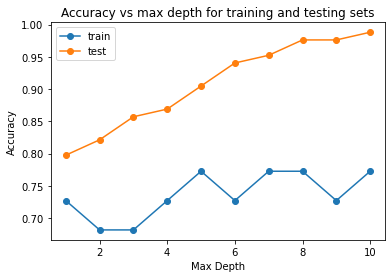

In [43]:
# Plot accuracy scores
fig, ax = plt.subplots()
ax.set_xlabel("Max Depth")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs max depth for training and testing sets")
ax.plot(N, accuracy_train, marker='o', label="train")
ax.plot(N, accuracy_test, marker='o', label="test")
ax.legend()
plt.show() 

### Random Forest Model
For our final model, we will look at random forests ensemble model to see if this would improve performance and accuracy of our model.

In [52]:
# Create and fit random forest
ecg_rf = RandomForestClassifier(max_depth=1).fit(ecg_X_train, ecg_Y_train)

In [53]:
# Perform predictions and get accuracy of new model
ecg_rf_predict_train = ecg_rf.predict(ecg_X_train)
ecg_rf_predict_test = ecg_rf.predict(ecg_X_test)

acc_rf_train = metrics.accuracy_score(ecg_Y_train, ecg_rf_predict_train, normalize=True)
acc_rf_test = metrics.accuracy_score(ecg_Y_test, ecg_rf_predict_test, normalize=True)
print(f"Accuracy of predictions for training set: {acc_rf_train}")
print(f"Accuracy of predictions for test set: {acc_rf_test}")

Accuracy of predictions for training set: 0.7619047619047619
Accuracy of predictions for test set: 0.6818181818181818


## Results and Analysis 
As noted above, we saw that the simple unbounded decision tree had an accuracy of .72 for the test set while our random forest model had one of .68. This is interesting as we would have expected the random forest to do a bit better. We can dig in a little deeper and look at metrics which are a little more meaningful than accuracy.

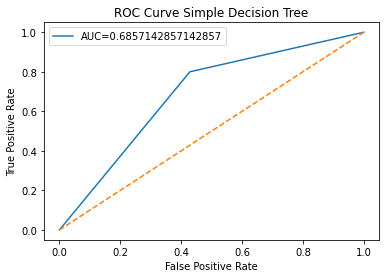

In [69]:
# Create ROC Curve for simple decision tree
ecg_pred_proba = ecg_dtc.predict_proba(ecg_X_test)[:,1]
auc_score = metrics.roc_auc_score(ecg_Y_test, ecg_pred_proba)

fpr, tpr, thr = metrics.roc_curve(ecg_Y_test, ecg_pred_proba)
plt.title('ROC Curve Simple Decision Tree')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr, label=f"AUC={auc_score}")
plt.plot([0,1],[0,1], ls='--')
plt.legend()
plt.show()

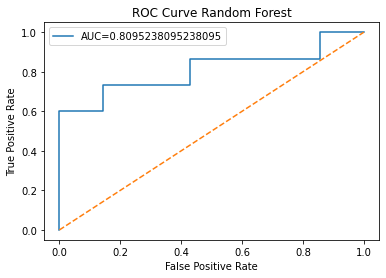

In [71]:
# Create ROC Curve for random forst decision tree
ecg_rf_pred_proba = ecg_rf.predict_proba(ecg_X_test)[:,1]
auc_score_rf = metrics.roc_auc_score(ecg_Y_test, ecg_rf_pred_proba)

fpr, tpr, thr = metrics.roc_curve(ecg_Y_test, ecg_rf_pred_proba)
plt.title('ROC Curve Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr, label=f"AUC={auc_score_rf}")
plt.plot([0,1],[0,1], ls='--')
plt.legend()
plt.show()

Looking at ROC we are given a different picture than accuracy. By this look, it appears that our random forest performs better than our more simplistic model.

## Discussion and Conclusion
I was interested to see through this project that methods we studied in class which provided better results did not always do so in practice. This was likely due to the sparcity of this data set, being only 106 samples after cleaning. In future projects, I will seek out data sets with more values, ideally >1000, to be able to effectively use some of the more advanced techniques. An interesting takeaway is that it is really important when designing a model to determine what is required from the domain expert. This will allow model creation which better focuses on something like pure accuracy or if more holistic performance is better.  

One note related to lack of data. When we were cleaning our data, we noticed that there were 26 rows which did not have values for the data we were interested in. For this project, the decision was made to drop those rows. In real world experiments though, especially with how small this data set was, we would likely want to follow up with the researchers and/or patients to determine if any of those values could be filled in.